This notebook plots the solutions. You can actually plot the progress while the solver is running to see if it makes sense.

Various imports:

In [2]:
%load_ext autoreload
%autoreload 2
# add path to code
import sys
sys.path.insert(0, '../source')

from params import rho_i,g,H,X,Y,resultsname,y_i,x_i,L,W,nx,ny
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython import display
import time
from scipy.integrate import simpson
from dolfinx.mesh import create_rectangle, CellType
from dolfinx.fem import Function, FunctionSpace,Expression
from mpi4py import MPI
from constitutive import potential
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
from setup import domain, z_s, z_b, q_inflow, q_dist

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load results:

In [3]:
b = np.load('./'+resultsname+'/b.npy')
N = np.load('./'+resultsname+'/N.npy')
qx = np.load('./'+resultsname+'/qx.npy')
qy = np.load('./'+resultsname+'/qy.npy')
t = np.load('./'+resultsname+'/t.npy')

# get water flow speed
q_m = np.sqrt(qx**2+qy**2)

In [4]:
q_total = q_inflow*W + q_dist*(W*L) #total water input (inflow + distributed)

V0 = FunctionSpace(domain, ("CG", 1))
p,p_norm_ = potential(z_b,z_s)

p_norm = Function(V0)
px = Function(V0)
py = Function(V0)

p_norm.interpolate(Expression(p_norm_, V0.element.interpolation_points()))
points = domain.geometry.x[:,0:2]
triang = Delaunay(points)

p_norm_int = LinearNDInterpolator(triang, p_norm.x.array)(X,Y)
sigma = 0.02/3.
storage = np.exp(1)**(-p_norm_int**8/sigma**8)

zb_int = LinearNDInterpolator(triang, z_b.x.array)(X,Y)
zs_int = LinearNDInterpolator(triang, z_s.x.array)(X,Y)

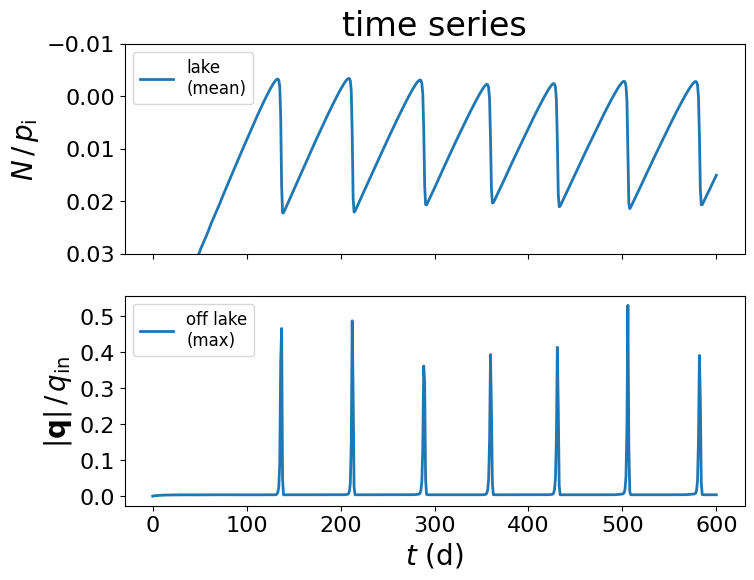

In [5]:
%matplotlib inline

p0 = rho_i*g*(zs_int-zb_int)
Nl_mean = np.mean(storage*N/p0,axis=(1,2))
q_max = np.max((1-storage)*q_m,axis=(1,2))

plt.figure(figsize=(8,6))
plt.subplot(211)
plt.title(r'time series',fontsize=24)
plt.plot(t*365./3.154e7,Nl_mean,linewidth=2,label='lake\n(mean)')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r'$N\,/\,p_\mathrm{i}$',fontsize=20)
plt.ylim(0.03,-0.01)
plt.gca().xaxis.set_ticklabels([])
plt.legend(fontsize=12,loc='upper left')


plt.subplot(212)
plt.plot(t*365./3.154e7,q_max/q_total,linewidth=2,label='off lake\n(max)')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r'$|\mathbf{q}|\,/\,q_\mathrm{in}$',fontsize=20)
plt.xlabel(r'$t$ (d)',fontsize=20)
plt.legend(fontsize=12,loc='upper left')
# plt.xlim(0,20)
plt.savefig('plot-'+resultsname)
plt.show()
plt.close()

Save png's for movie:

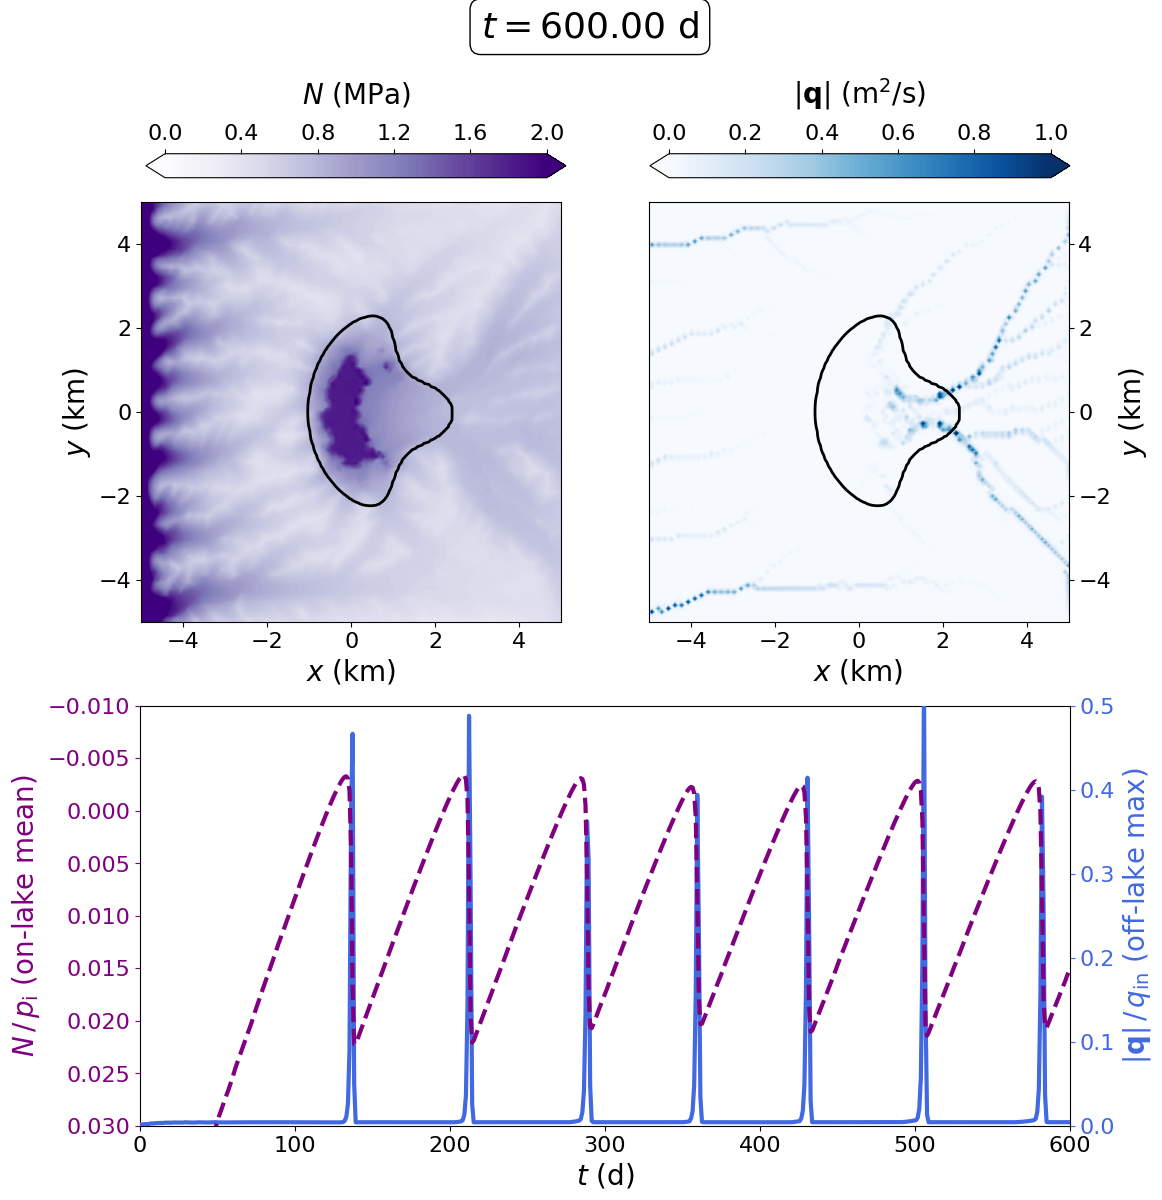

In [6]:
!rm -r movie_{resultsname}
!mkdir movie_{resultsname}

# use agg backend for saving pngs
mpl.use('agg')

j=0
ind = np.arange(0,t.size,1)

ind = np.array([t.size-1])
%matplotlib inline

for i in ind:
    print('saved image '+str(j+1)+' out of '+str(ind.size)+' \r',end='')
    
    if np.abs(b[i,:,:]).min()>1e-7:
        fig = plt.figure(figsize=(12,12))
                
        plt.suptitle(r'$t=$'+'{:.2f}'.format(365*t[i]/3.154e7)+' d',y=1.04,fontsize=26,bbox=dict(boxstyle='round', facecolor='w', alpha=1))

        plt.subplot(221)
        N_i = N[i,:,:]
        p1 = plt.contourf(X/1e3,Y/1e3,N_i/1e6,levels=np.linspace(0,2,100),cmap='Purples',extend='both')
        plt.contour(X/1e3,Y/1e3,storage,levels=[0.001],colors='k',linestyles='-',linewidths=2)
        plt.gca().set_aspect('equal', 'box')
        plt.xlabel(r'$x$ (km)',fontsize=20)
        plt.ylabel(r'$y$ (km)',fontsize=20)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        cbar_ax = fig.add_axes([0.13, 0.9, 0.35, 0.02])
        cbar = plt.colorbar(p1,orientation='horizontal',ticks=np.linspace(0,2,6),cax=cbar_ax)
        cbar.set_label(r'$N$ (MPa)',fontsize=20,labelpad=15)
        cbar.ax.tick_params(labelsize=16)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.xaxis.set_label_position('top')

        
        plt.subplot(222)
        q_i = q_m[i,:,:]
        p2 = plt.contourf(X/1e3,Y/1e3,q_i,cmap='Blues',levels=np.linspace(0,1,100),extend='both')
        plt.contour(X/1e3,Y/1e3,storage,levels=[0.001],colors='k',linestyles='-',linewidths=2)
        plt.gca().set_aspect('equal', 'box')
        plt.xlabel(r'$x$ (km)',fontsize=20)
        plt.gca().yaxis.set_label_position("right")
        plt.gca().yaxis.tick_right()
        plt.ylabel(r'$y$ (km)',fontsize=20)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        cbar_ax = fig.add_axes([0.55, 0.9, 0.35, 0.02])
        cbar = plt.colorbar(p2,orientation='horizontal',ticks=np.linspace(0,1,6),cax=cbar_ax)
        cbar.set_label(r'$|\mathbf{q}|$ (m$^2$/s)',fontsize=20,labelpad=15)
        cbar.ax.tick_params(labelsize=16)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.xaxis.set_label_position('top')
        
        plot = plt.subplot(212)
        ax2 = plt.gca()
        plt.plot(t[0:i]*365./3.154e7,Nl_mean[0:i],color='purple',linestyle='--',linewidth=3,label='lake\n(mean)',zorder=100)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.gca().tick_params(axis='y', colors="purple")
        plt.ylabel(r'$N\,/\,p_\mathrm{i}$ (on-lake mean)',fontsize=20,color='purple')
        plt.ylim(0.03,-0.01)
        plt.xlabel(r'$t$ (d)',fontsize=20)
        plt.xlim(0,t.max()*365./3.154e7)

        plt.gca().twinx()
        plt.plot(t[0:i]*365./3.154e7,q_max[0:i]/q_total,color='royalblue',linewidth=3,label='off lake\n(max)',zorder=10)
        plt.gca().yaxis.set_label_position("right")
        plt.gca().yaxis.tick_right()   
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.gca().tick_params(axis='y', colors="royalblue")
        plt.ylabel(r'$|\mathbf{q}|\,/\,q_\mathrm{in}$ (off-lake max)',fontsize=20,color='royalblue')
        plt.xlabel(r'$t$ (d)',fontsize=20)
        plt.xlim(0,t.max()*365./3.154e7)
        plt.ylim(0.0,0.5)
        plt.savefig('./movie_'+resultsname+'/'+str(j),bbox_inches='tight')
        plot.set_zorder(ax2.get_zorder()+1)
        plot.set_frame_on(False)
        plt.show()
        plt.close()
        j+=1